# Reinforcement Learning (MO436)

Autores:

**Aline Cavalca Caravlho Soares de Azevedo** (RA: )

**Beatriz Cardoso Nascimento**               (RA: )

**Daniel Gardin Gratti**                     (RA: 214729)

**Guilhermo de Luiggi Mocelim de Oliveira** (RA: )


## Introdução

In [1]:
from collections import defaultdict
from pacman.actions import Actions
from pacman.env import PacmanEnv
from pacman.agents import Agent
from typing import Any

import matplotlib.pyplot as plt
import numpy as np

In [3]:
env = PacmanEnv.contourDanger(7, ghost_name= "FollowGhost")

### Monte Carlo

In [76]:
class MonteCarlo(Agent):
    def __init__(self, env, gamma, alpha=None, N0=1):
        self.env    = env
        self.gamma  = gamma
        self.alpha = alpha
        self.N0    = N0
        
        self.Qtable = defaultdict(lambda : {action: 0 for action in Actions.actions})
    
    def train(self, max_episodes=1000):
        curr_episode = 0

        history = {
            "cumulative reward"  : [],
            "episode error" : []
        }

        Ntable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

        while curr_episode < max_episodes:

            state, done = self.env.reset()
            cumulative_reward = 0
            cumulative_error  = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = self.act(state, epsilon)
                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
               
                cumulative_reward = (self.gamma * cumulative_reward) + reward

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                error = (cumulative_reward - self.Qtable[state][action])

                cumulative_error += abs(error)

                self.Qtable[state][action] += alpha * error

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)

            curr_episode += 1
        
        return history


    def act(self, state, epsilon=0):
        if np.random.rand() > epsilon:
            action = max(self.Qtable[state], key=self.Qtable[state].get)

        else:
            action = Actions.sample()

        return action

In [95]:
monte_carlo = MonteCarlo(env.set_render(None), 0.99)
mc_history = monte_carlo.train(10000)

In [96]:
env.set_render('ansi')
env.run_policy(monte_carlo, 0, .5);

% % % % % % % % %
% ^             %
% M             %
%               %
%               %
%               %
%               %
%               %
% % % % % % % % %
Score: 1


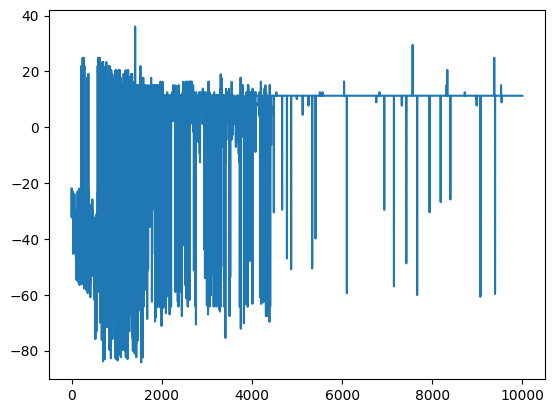

In [97]:
plt.plot(mc_history["cumulative reward"])

### Q-Learning

In [85]:
class QLearning(Agent):
    def __init__(self, env, gamma, alpha=None, N0=1):
        self.env   = env
        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0
        
        self.Qtable = defaultdict(lambda : {action: 0 for action in Actions.actions})  # type: ignore

    
    def train(self, max_episodes=None, tol=1e-7):
        curr_episode = 0

        history = {
            "cumulative reward"  : [],
            "episode error" : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        while curr_episode < max_episodes:

            state, done = self.env.reset()
            cumulative_reward = 0
            cumulative_error  = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = self.act(state, epsilon)
                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                td_error = reward + self.gamma * max(self.Qtable[next_state].values()) - self.Qtable[state][action]

                cumulative_error += abs(td_error)

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                self.Qtable[state][action] += alpha * td_error

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)

            curr_episode += 1

        return history


    def act(self, state, epsilon=0):
        if np.random.rand() > epsilon:
            action = max(self.Qtable[state], key=self.Qtable[state].get)

        else:
            action = Actions.sample()

        return action

In [86]:
q_learning = QLearning(env.set_render(None), 0.99)
q_history = q_learning.train(5000)

In [87]:
env.set_render('ansi')
env.run_policy(q_learning, 0, .5);

% % % % % % % % %
% < E           %
%               %
%               %
%               %
%               %
%               %
%               %
% % % % % % % % %
Score: 37


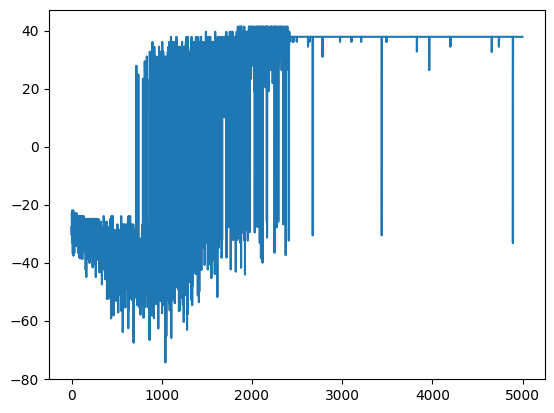

In [88]:
plt.plot(q_history["cumulative reward"])

### SARSA($\lambda$)

In [89]:
class SARSAgent(Agent):
    def __init__(self, env, gamma, lmbda, alpha=None, N0=1):
        self.env   = env
        self.gamma = gamma
        self.lmbda = lmbda
        self.alpha = alpha
        self.N0    = N0

        self.Qtable = defaultdict(lambda : {action: 0 for action in Actions.actions})


    def train(self, max_episodes=None, tol=1e-7):
        curr_episode = 0

        history = {
            "cumulative reward"  : [],
            "episode error" : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        while curr_episode < max_episodes:
            
            Etable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

            state, done = self.env.reset()
            action = self.act(state, epsilon=1)

            cumulative_reward = 0
            cumulative_error  = 0

            while not done:
                Etable[state][action] = Etable[state][action] + 1
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                next_state, reward, done, info = self.env.step(action)
                next_action = self.act(next_state, epsilon)

                Ntable[state][action] += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                td_error = reward + self.gamma * self.Qtable[next_state][next_action] - self.Qtable[state][action]

                cumulative_error += abs(td_error)

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                self.update_tables(Etable, alpha, td_error)

                state  = next_state
                action = next_action

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)

            curr_episode += 1
        
        return history


    def act(self, state, epsilon=0):
        if np.random.rand() > epsilon:
            action = max(self.Qtable[state], key=self.Qtable[state].get)

        else:
            action = Actions.sample()

        return action

    def update_tables(self, Etable, alpha, td_error):
        for state in Etable:
            for action in Actions.actions:
                self.Qtable[state][action] += td_error * alpha * Etable[state][action]
                Etable[state][action] *= self.gamma * self.lmbda

In [92]:
sarsa = SARSAgent(env.set_render(None), 0.99, 0.2)
sarsa_history = sarsa.train(5000)

In [93]:
env.set_render('ansi')
env.run_policy(sarsa, 0, .5);

% % % % % % % % %
% ^             %
% E             %
%               %
%               %
%               %
%               %
%               %
% % % % % % % % %
Score: 37


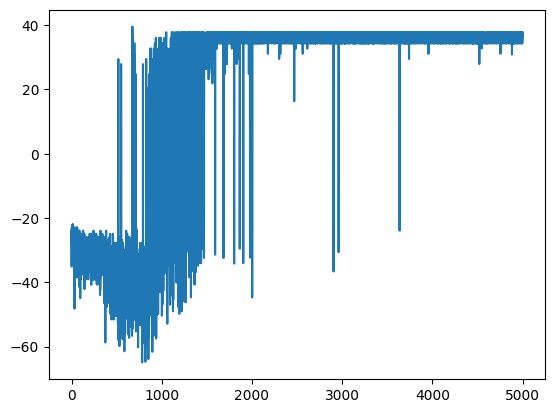

In [94]:
plt.plot(sarsa_history["cumulative reward"])